In [1]:
import graph_fourier_transform
import graph_ruggedness_de
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import networkx as nx
import os
import matplotlib.ticker as ticker
import matplotlib.colors as colors
import matplotlib.cm as cm
from scipy.stats import spearmanr
import brownian_motion
import matplotlib as mpl
from collections import defaultdict
import os

Building approx. NN index.
Done.


Adding OHE vectors to index.: 1618it [00:00, 9737.41it/s]


Building approx. NN search tree(s).
Done.


Adding approximate KNN edges.: 1618it [00:00, 27804.50it/s]
Computing local Dirichlet energy.: 1618it [00:00, 1628.20it/s]


Building approx. NN index.
Done.


Adding OHE vectors to index.: 1130it [00:00, 10078.20it/s]


Building approx. NN search tree(s).
Done.


Adding approximate KNN edges.: 1130it [00:00, 38138.01it/s]
Computing local Dirichlet energy.: 1130it [00:00, 1275.62it/s]


Building approx. NN index.
Done.


Adding OHE vectors to index.: 1110it [00:00, 13359.96it/s]


Building approx. NN search tree(s).
Done.


Adding approximate KNN edges.: 1110it [00:00, 35242.78it/s]
Computing local Dirichlet energy.: 1110it [00:00, 1359.16it/s]


Building approx. NN index.
Done.


Adding OHE vectors to index.: 195it [00:00, 3527.57it/s]


Building approx. NN search tree(s).
Done.


Adding approximate KNN edges.: 195it [00:00, 50063.62it/s]


Connecting components


Computing local Dirichlet energy.: 195it [00:00, 9818.72it/s]


Building approx. NN index.
Done.


Adding OHE vectors to index.: 651it [00:00, 3216.41it/s]


Building approx. NN search tree(s).
Done.


Adding approximate KNN edges.: 651it [00:00, 35169.98it/s]
Computing local Dirichlet energy.: 651it [00:00, 1032.55it/s]


Building approx. NN index.
Done.


Adding OHE vectors to index.: 224it [00:00, 2256.56it/s]


Building approx. NN search tree(s).
Done.


Adding approximate KNN edges.: 224it [00:00, 45922.29it/s]
Computing local Dirichlet energy.: 224it [00:00, 9607.96it/s]


Building approx. NN index.
Done.


Adding OHE vectors to index.: 90it [00:00, 1004.03it/s]


Building approx. NN search tree(s).
Done.


Adding approximate KNN edges.: 90it [00:00, 19497.31it/s]
Computing local Dirichlet energy.: 90it [00:00, 5051.62it/s]


Building approx. NN index.
Done.


Adding OHE vectors to index.: 214it [00:00, 1718.59it/s]


Building approx. NN search tree(s).
Done.


Adding approximate KNN edges.: 214it [00:00, 20076.52it/s]

Connecting components



Computing local Dirichlet energy.: 214it [00:00, 9500.12it/s]


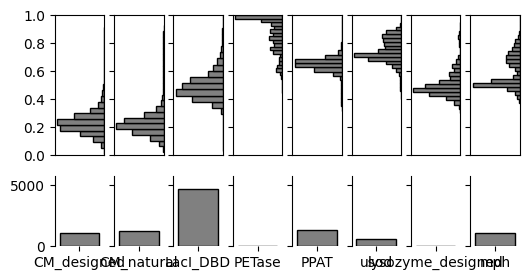

In [111]:
file_list = os.listdir('../data_files/sparse_datasets/')
# Remove unwanted files like '.DS_Store'
file_list = [file for file in file_list if file != '.DS_Store']
file_list.sort()  # Ensure consistent order

# Initialize a list to store BF values
bf_values = []

# Create a figure with 2 rows and the number of files as columns
n_files = len(file_list)
fig, axes = plt.subplots(nrows=2, ncols=n_files, figsize=(6, 3), gridspec_kw={'height_ratios': [2, 1]})

# Iterate through files and corresponding axes
for idx, (file, ax_col) in enumerate(zip(file_list, axes.T)):
    # ax_col is an array of two axes: [hist_ax, bar_ax]
    hist_ax = ax_col[0]
    bar_ax = ax_col[1]

    # Read and preprocess data
    df = pd.read_csv(f'../data_files/sparse_datasets/{file}')
    df = df.dropna()
    seq_ls = df['sequence'].tolist()
    values = df['fitness'].tolist()
    scaler = MinMaxScaler()
    # Optionally scale values
    # values = scaler.fit_transform(np.array(values).reshape(-1,1)).flatten()

    # Build graph and compute metrics
    G_k = graph_ruggedness_de.build_ohe_graph(
        seq_ls=seq_ls,
        values=values,
        edges=True,
        hamming_edges=False,
        approximate=True,
        n=int(np.sqrt(len(df)))
    )

    graph_ruggedness_de.compute_local_dirichlet_energy(G=G_k, approximate=False)
    de = graph_ruggedness_de.compute_dirichlet_energy_approximate(G=G_k)

    h0_prior_arr = brownian_motion.sample_prior_dist(
        G=G_k,
        ruggedness_fn=graph_ruggedness_de.compute_dirichlet_energy,
        local=False,
        replicates=100
    )

    h1_prior_arr = brownian_motion.sample_rugged_prior_dist(
        G=G_k,
        ruggedness_fn=graph_ruggedness_de.compute_dirichlet_energy,
        local=False,
        replicates=100
    )

    # Compute ground truth log(P)
    bf = brownian_motion.compute_marginal_likelihoods(
        h0_array=h0_prior_arr,
        h1_array=h1_prior_arr,
        empirical_val=de
    )

    # Append BF value to the list
    bf_values.append(bf)

    # Compute sequence identity matrix
    unique_chars = set(''.join(seq_ls))
    char_to_int = {char: idx for idx, char in enumerate(sorted(unique_chars))}

    A = np.zeros((len(seq_ls), len(seq_ls[0])), dtype=np.int8)
    for i, seq in enumerate(seq_ls):
        A[i] = [char_to_int[char] for char in seq]

    # Compute sequence identity matrix
    batch_size = 100  # Adjust based on your memory capacity
    sequence_identity_matrix = np.zeros((len(seq_ls), len(seq_ls)))

    for i_batch in range(0, len(seq_ls), batch_size):
        A_batch = A[i_batch:i_batch+batch_size]
        A_expanded1 = A_batch[:, np.newaxis, :]
        matches = (A_expanded1 == A[np.newaxis, :, :])
        num_identical_positions = np.sum(matches, axis=2)
        sequence_identity_matrix[i_batch:i_batch+batch_size] = num_identical_positions / len(seq_ls[0])

    n = sequence_identity_matrix.shape[0]
    lower_tri_indices = np.tril_indices(n, k=-1)
    lower_triangle_values = sequence_identity_matrix[lower_tri_indices]

    # Plot the histogram rotated 90 degrees on hist_ax
    hist_ax.hist(lower_triangle_values.flatten(), bins=22, orientation='horizontal', color='grey', edgecolor='black')
    hist_ax.set_ylim(0, 1)
    hist_ax.invert_xaxis()  # Invert x-axis to stack properly

    if idx != 0:
        hist_ax.set_yticklabels([])
        hist_ax.set_xticklabels([])
    

    # Remove spines and ticks for clarity
    hist_ax.spines['top'].set_visible(True)
    hist_ax.spines['right'].set_visible(True)
    hist_ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    # Plot the bar graph on bar_ax
    bar_ax.bar(file.strip('.csv'), bf, color='grey', edgecolor='black')
    bar_ax.set_xlim(-0.5, 0.5)
    bar_ax.set_ylim(0,5700)

    if idx != 0:
        bar_ax.set_yticklabels([])
    
    

    # Remove spines for clarity
    bar_ax.spines['top'].set_visible(False)
    bar_ax.spines['right'].set_visible(False)
    bar_ax.spines['bottom'].set_visible(False)

# After the loop, adjust y-limits and y-ticks
# Compute the maximum BF value with some padding
# max_bf_value = max(bf_values) * 1.1  # Add 10% padding

# # Define y-ticks based on the maximum BF value
# y_ticks = np.linspace(0, max_bf_value, num=5)

# # Adjust y-limits and y-ticks for all bar plots
# for ax in axes[1, :]:
#     ax.set_ylim(0, max_bf_value)
#     ax.set_yticks(y_ticks)
#     ax.set_yticklabels([f'{tick:.2f}' for tick in y_ticks])
#     ax.tick_params(axis='y', labelsize=8)

# Show the plot
plt.savefig('figures/Figure_5alt/logBF_identity_dists.pdf')
plt.show()

Building approx. NN index.
Done.


Adding OHE vectors to index.: 1618it [00:00, 9439.08it/s]


Building approx. NN search tree(s).
Done.


Adding approximate KNN edges.: 1618it [00:00, 17938.73it/s]
Computing local Dirichlet energy.: 1618it [00:00, 1974.23it/s]
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_50492/2798627847.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis', 10)
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_50492/2798627847.py:36: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 275x175 with 0 Axes>

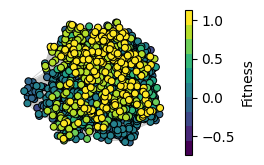

/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_50492/2798627847.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('plasma', 10)
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_50492/2798627847.py:58: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 275x175 with 0 Axes>

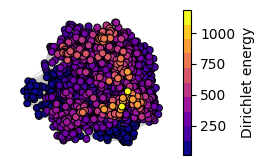

Building approx. NN index.
Done.


Adding OHE vectors to index.: 1130it [00:00, 8663.24it/s]


Building approx. NN search tree(s).
Done.


Adding approximate KNN edges.: 1130it [00:00, 24417.65it/s]
Computing local Dirichlet energy.: 1130it [00:01, 1016.12it/s]
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_50492/2798627847.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis', 10)
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_50492/2798627847.py:36: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 275x175 with 0 Axes>

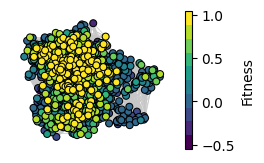

/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_50492/2798627847.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('plasma', 10)
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_50492/2798627847.py:58: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 275x175 with 0 Axes>

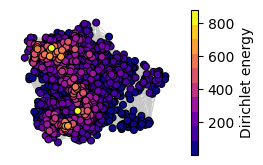

Building approx. NN index.
Done.


Adding OHE vectors to index.: 1110it [00:00, 13796.52it/s]


Building approx. NN search tree(s).
Done.


Adding approximate KNN edges.: 1110it [00:00, 35184.45it/s]
Computing local Dirichlet energy.: 1110it [00:00, 1440.38it/s]
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_50492/2798627847.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis', 10)
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_50492/2798627847.py:36: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 275x175 with 0 Axes>

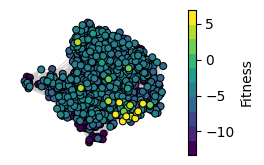

/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_50492/2798627847.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('plasma', 10)
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_50492/2798627847.py:58: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 275x175 with 0 Axes>

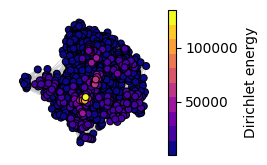

Building approx. NN index.
Done.


Adding OHE vectors to index.: 195it [00:00, 3033.75it/s]


Building approx. NN search tree(s).
Done.


Adding approximate KNN edges.: 195it [00:00, 51725.86it/s]
Computing local Dirichlet energy.: 195it [00:00, 6571.40it/s]
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_50492/2798627847.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis', 10)
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_50492/2798627847.py:36: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 275x175 with 0 Axes>

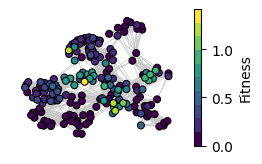

/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_50492/2798627847.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('plasma', 10)
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_50492/2798627847.py:58: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 275x175 with 0 Axes>

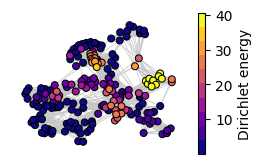

Building approx. NN index.
Done.


Adding OHE vectors to index.: 651it [00:00, 2589.54it/s]


Building approx. NN search tree(s).
Done.


Adding approximate KNN edges.: 651it [00:00, 28520.16it/s]
Computing local Dirichlet energy.: 651it [00:00, 825.98it/s]
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_50492/2798627847.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis', 10)
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_50492/2798627847.py:36: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 275x175 with 0 Axes>

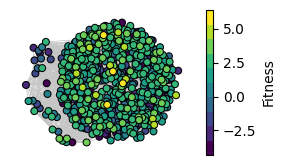

/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_50492/2798627847.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('plasma', 10)
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_50492/2798627847.py:58: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 275x175 with 0 Axes>

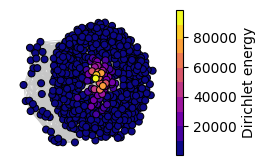

Building approx. NN index.
Done.


Adding OHE vectors to index.: 224it [00:00, 2075.57it/s]


Building approx. NN search tree(s).
Done.


Adding approximate KNN edges.: 224it [00:00, 35921.40it/s]
Computing local Dirichlet energy.: 224it [00:00, 8393.33it/s]
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_50492/2798627847.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis', 10)
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_50492/2798627847.py:36: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 275x175 with 0 Axes>

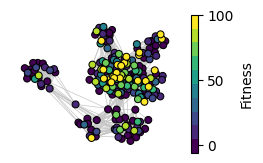

/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_50492/2798627847.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('plasma', 10)
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_50492/2798627847.py:58: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 275x175 with 0 Axes>

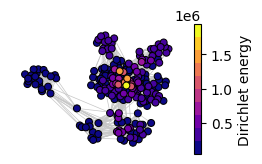

Building approx. NN index.
Done.


Adding OHE vectors to index.: 90it [00:00, 1368.15it/s]


Building approx. NN search tree(s).
Done.


Adding approximate KNN edges.: 90it [00:00, 20394.80it/s]
Computing local Dirichlet energy.: 90it [00:00, 3824.28it/s]
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_50492/2798627847.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis', 10)
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_50492/2798627847.py:36: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 275x175 with 0 Axes>

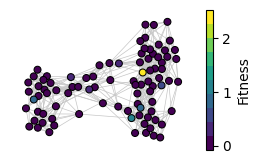

/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_50492/2798627847.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('plasma', 10)
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_50492/2798627847.py:58: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 275x175 with 0 Axes>

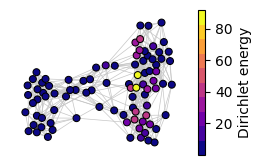

Building approx. NN index.
Done.


Adding OHE vectors to index.: 214it [00:00, 1493.35it/s]


Building approx. NN search tree(s).
Done.


Adding approximate KNN edges.: 214it [00:00, 42251.04it/s]

Connecting components



Computing local Dirichlet energy.: 214it [00:00, 9439.68it/s]
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_50492/2798627847.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis', 10)
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_50492/2798627847.py:36: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 275x175 with 0 Axes>

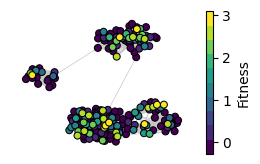

/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_50492/2798627847.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('plasma', 10)
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_50492/2798627847.py:58: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 275x175 with 0 Axes>

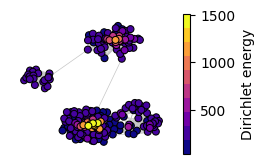

In [117]:
file_list = os.listdir('../data_files/sparse_datasets/')
# Remove unwanted files like '.DS_Store'
file_list = [file for file in file_list if file != '.DS_Store']
file_list.sort()  # Ensure consistent order

for file in file_list:
    

    df = pd.read_csv(f'../data_files/sparse_datasets/{file}')
    df = df.dropna()
    seq_ls = df['sequence'].tolist()
    values = df['fitness'].tolist()

    G_k = graph_ruggedness_de.build_ohe_graph(seq_ls=seq_ls,
                                            values=values,
                                            edges=True,
                                            hamming_edges=False, 
                                            approximate=True,
                                            n=int(np.sqrt(len(df))))

    graph_ruggedness_de.compute_local_dirichlet_energy(G=G_k,
                                                    approximate=False)

    #Plotting graphs
    values = [node[1]['value'] for node in G_k.nodes(data=True)]
    viridis = plt.cm.get_cmap('viridis', 10)
    pos = nx.spring_layout(G_k, k=0.35)

    nodes_sorted_by_value = sorted(G_k.nodes(data=True), key=lambda x: x[1]['value'])
    node_colors = [viridis((node[1]['value'] - min(values)) / (max(values) - min(values))) for node in nodes_sorted_by_value]
    nodes_sorted = [node[0] for node in nodes_sorted_by_value]


    plt.figure(figsize=(2.75, 1.75))
    fig, ax = plt.subplots(figsize=(2.75, 1.75), constrained_layout=True)
    plt.tight_layout()
    nx.draw(G_k, pos, nodelist=nodes_sorted, node_color=node_colors, with_labels=False, edgecolors='black', node_size=25, width=0.5, edge_color='#C6C6C6', linewidths=0.75)
    sm = mpl.cm.ScalarMappable(cmap=viridis, norm=plt.Normalize(vmin=min(values), vmax=max(values)))
    sm.set_array([])  # This is needed to avoid a warning
    # Add colorbar with label
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Fitness')

    plt.tight_layout()
    plt.savefig(f'figures/Figure_5alt/{file.strip(".csv")}_fitness_graph.pdf')
    plt.show()

    values = [node[1]['local_dirichlet'] for node in G_k.nodes(data=True)]
    viridis = plt.cm.get_cmap('plasma', 10)

    nodes_sorted_by_value = sorted(G_k.nodes(data=True), key=lambda x: x[1]['local_dirichlet'])
    node_colors = [viridis((node[1]['local_dirichlet'] - min(values)) / (max(values) - min(values))) for node in nodes_sorted_by_value]
    nodes_sorted = [node[0] for node in nodes_sorted_by_value]


    plt.figure(figsize=(2.75, 1.75))
    fig, ax = plt.subplots(figsize=(2.75, 1.75), constrained_layout=True)
    plt.tight_layout()
    nx.draw(G_k, pos, nodelist=nodes_sorted, node_color=node_colors, with_labels=False, edgecolors='black', node_size=25, width=0.5, edge_color='#C6C6C6', linewidths=0.75)
    sm = mpl.cm.ScalarMappable(cmap=viridis, norm=plt.Normalize(vmin=min(values), vmax=max(values)))
    sm.set_array([])  # This is needed to avoid a warning
    # Add colorbar with label
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Dirichlet energy')

    plt.tight_layout()
    plt.savefig(f'figures/Figure_5alt/{file.strip(".csv")}_local_de_graph.pdf')
    plt.show()

In [90]:
file

'.DS_Store'

LacI - 
PETase - 
DropSynth paper - 
Progen lysozyme -
Yang CLEAN MDH
Yang CLEAN SOD
Covid spike - 
SH3 Ragnatham -
Chorismate mutase Ragnatham -/-


Need ID% distribution - compare between similar ID % distributions
